## Предсказание отвала игроков через месяц в онлайн-игре на платформе iOs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline  

Загрузим данные:

In [2]:
data = pd.read_csv('practice_sessions_ios.csv', sep='|', names=['id', 'session_number', 'session_length',
                                                                'session_start_time', 'session_end_time', 'actdate'])
data['actdate'] = pd.to_datetime(data['actdate'])

In [3]:
data.head()

,id,session_number,session_length,session_start_time,session_end_time,actdate
0,00e954a1b3,12.0,29,1486997200,1486997229,2017-02-13
1,028498cd03,1.0,445,1485039376,1485039821,2017-01-21
2,12ab1dfa82,8.0,0,1486756815,1486756815,2017-02-10
3,0a0a1ffe3b,5.0,2846,1484976494,1484979340,2017-01-21
4,01c68437aa,7.0,1610,1484329332,1484330942,2017-01-13


# Overview

Перед тем, как приступить к предсказанию, немного посмотрим, что представляют из себя данные:

**Распределение количества сессий по дням:**

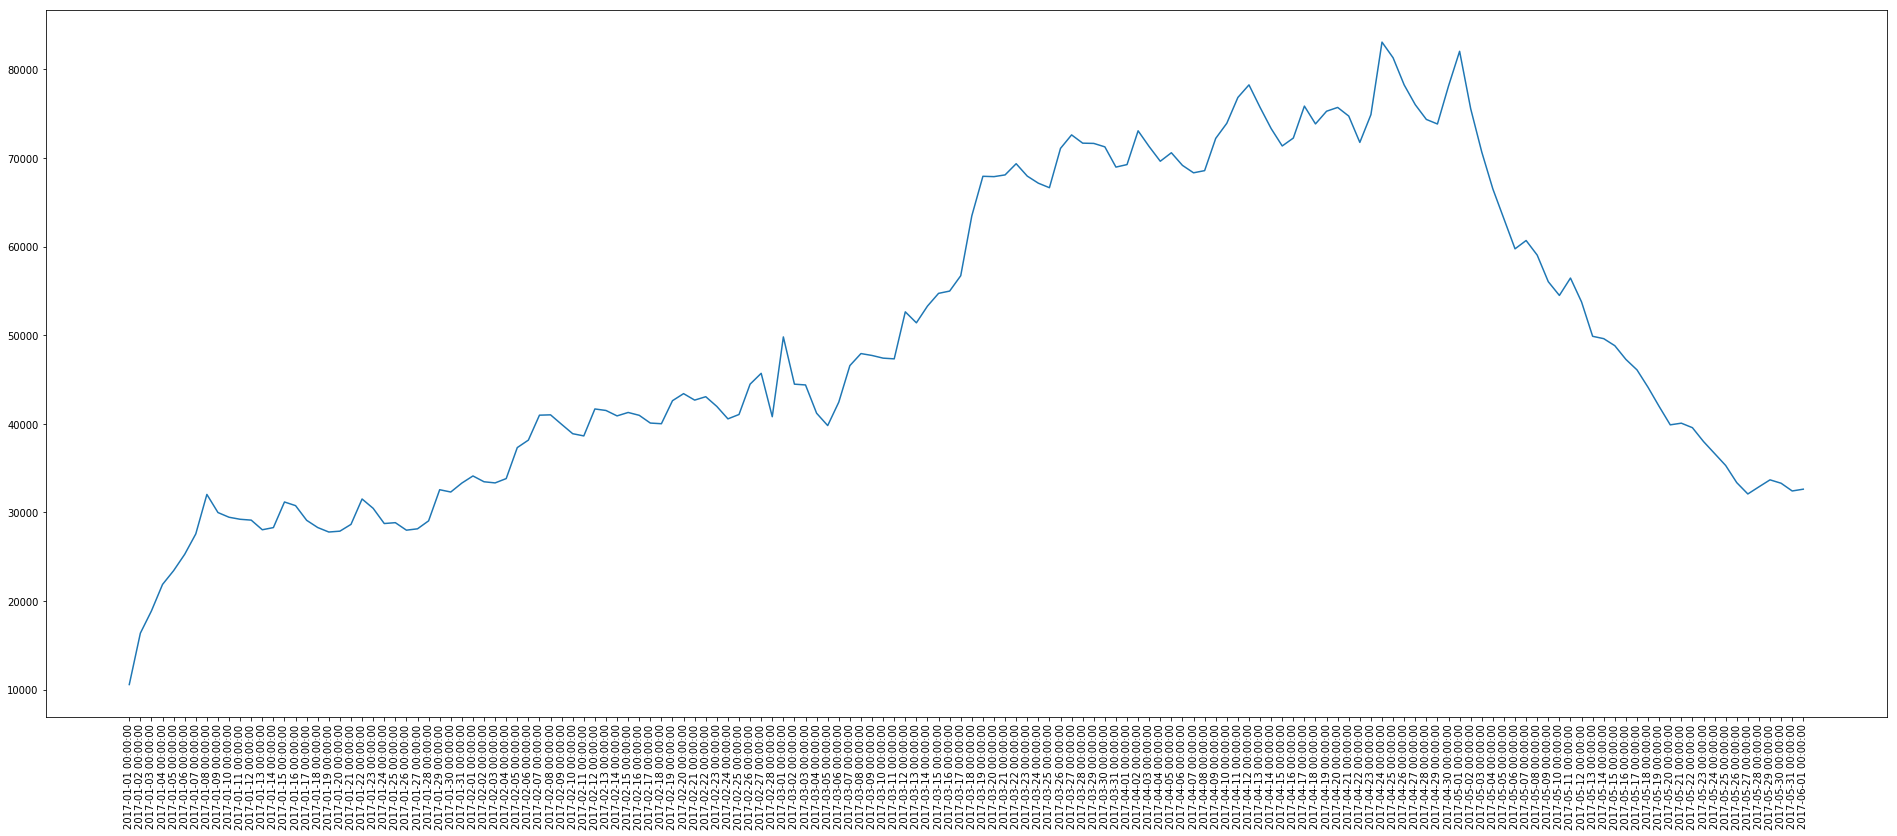

In [4]:
sessions_per_day = data[['actdate', 'id']].groupby('actdate').count().reset_index().rename(columns={'id':'count_sessions'})

fig = plt.figure(figsize=(33, 13))
plt.plot(sessions_per_day[['count_sessions']].values)
plt.xticks(np.arange(sessions_per_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in sessions_per_day['actdate'].values], rotation=90);

Так как до определенного момента наблюдался почти постоянный рост количества сессий, брать топ 10% дней и смотреть на их дни недели неразумно, так что посмотрим на пики (чтоб проверить теорию, что больше всего играют по выходным):

Пики по дням недели:

In [5]:
from scipy.signal import argrelextrema
from datetime import datetime
import calendar

peaks = sessions_per_day['actdate'][argrelextrema(sessions_per_day[['count_sessions']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Sunday       10
Wednesday    10
Monday        7
Thursday      2
Name: 0, dtype: int64

**Распределение числа уникальных пользователей в игре по дням:**

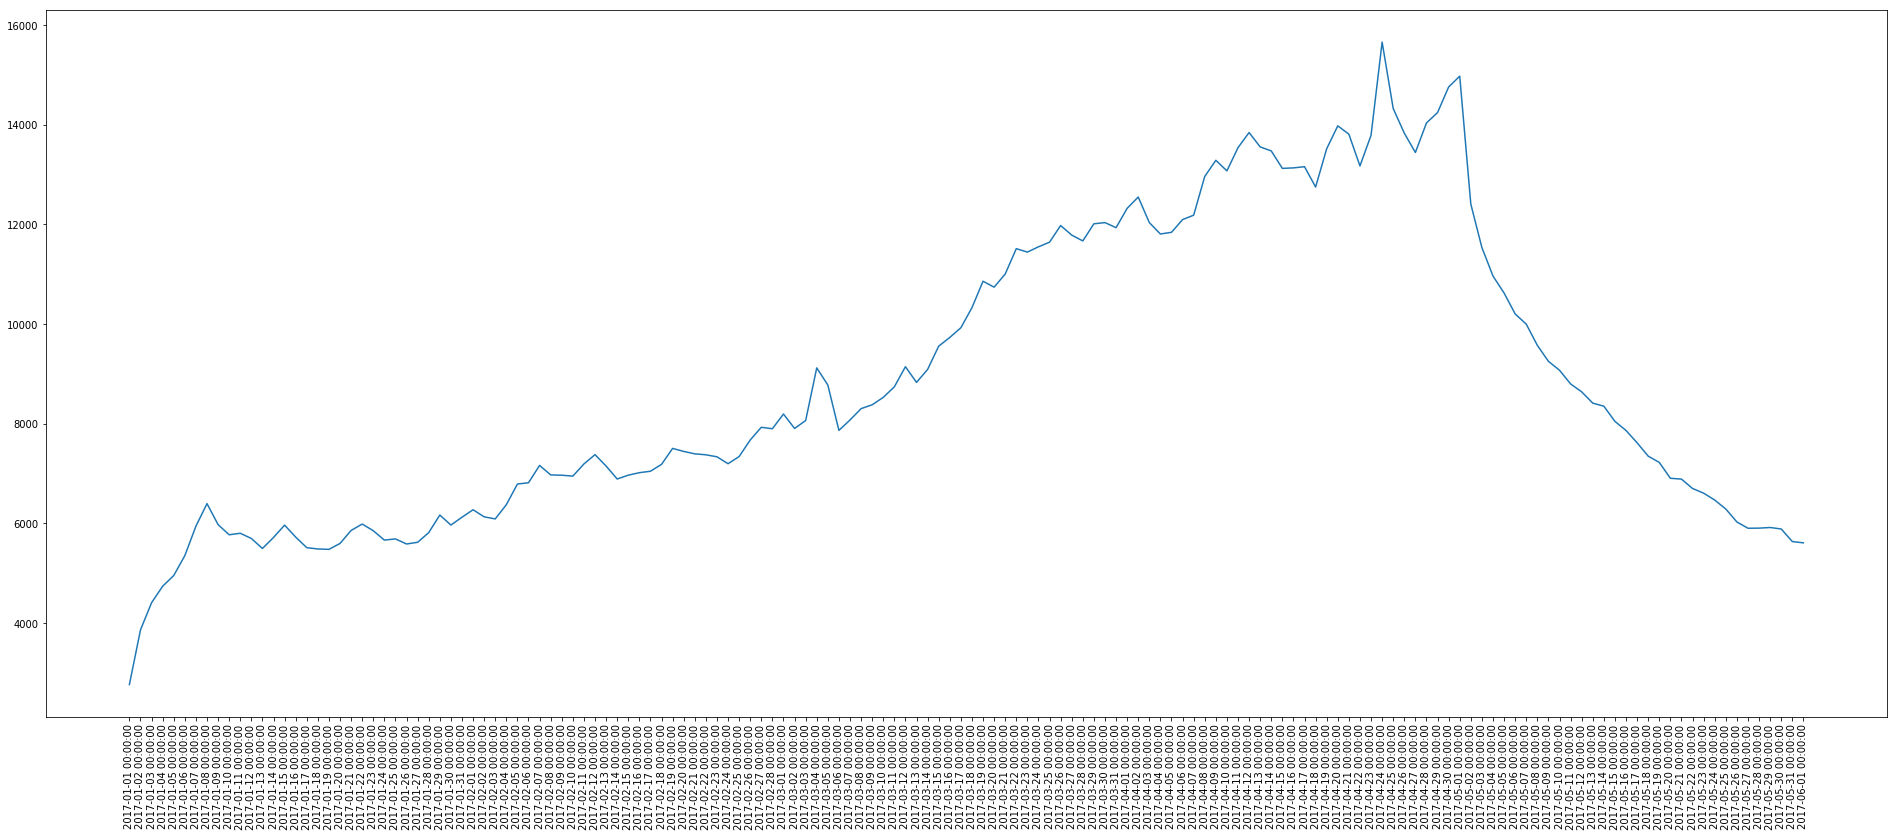

In [6]:
players_per_day = data.groupby(['actdate', 'id']).count().reset_index()[['actdate', 'id']].groupby('actdate').count().reset_index().rename(columns={'id':'count_players'})

fig = plt.figure(figsize=(33, 13))
plt.plot(players_per_day[['count_players']].values)
plt.xticks(np.arange(players_per_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in players_per_day['actdate'].values], rotation=90);

In [7]:
peaks = players_per_day['actdate'][argrelextrema(players_per_day[['count_players']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Sunday       11
Wednesday     6
Monday        5
Thursday      2
Tuesday       1
Saturday      1
Name: 0, dtype: int64

**Распределение регистрации новых пользователей по дням:**

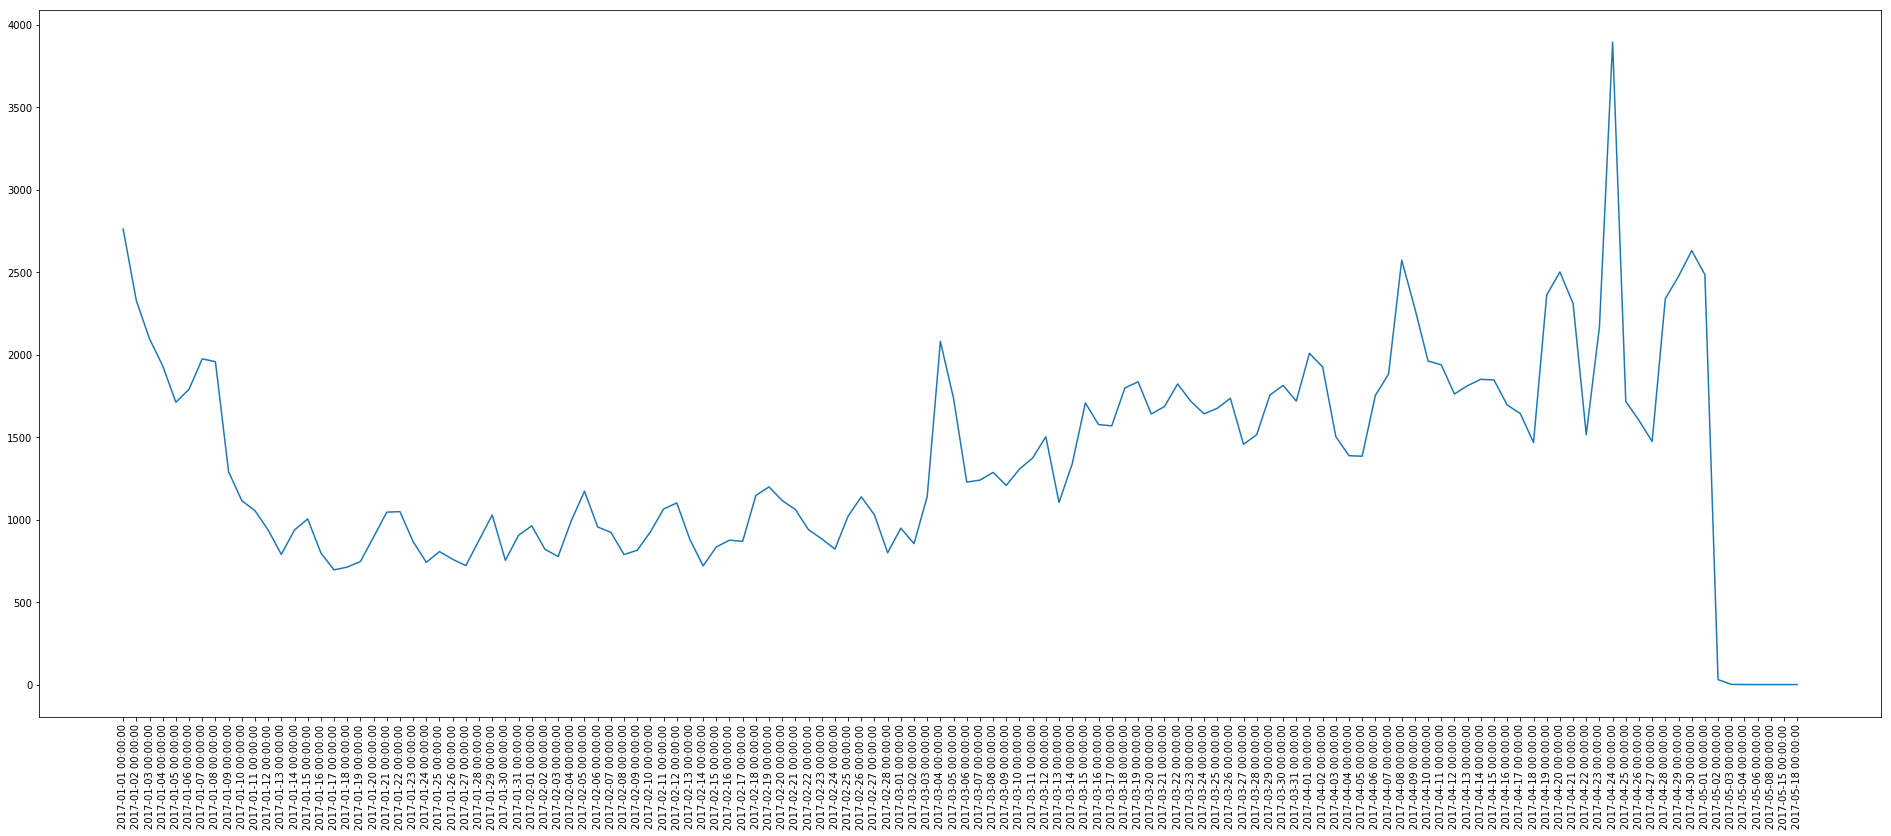

In [8]:
first_appearances = data[['id', 'actdate']].sort_values('actdate').groupby(['id']).first().reset_index()
first_appearances.columns = ['id', 'first_appearance']
growth_by_day = first_appearances.reset_index().groupby('first_appearance').count().reset_index().rename(columns={'id':'count_new_players'})

fig = plt.figure(figsize=(33, 13))
plt.plot(growth_by_day[['count_new_players']].values)
plt.xticks(np.arange(growth_by_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in growth_by_day['first_appearance'].values], rotation=90);

In [9]:
peaks = growth_by_day['first_appearance'][argrelextrema(growth_by_day[['count_new_players']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Sunday       11
Wednesday     6
Saturday      4
Thursday      3
Friday        1
Monday        1
Name: 0, dtype: int64

Видно, что больше всего играют в выходные, а так же в середине недели, в среду.

# Prediction

Задача - по данным игроков за первые 30 дней, проведенных ими в игре, предсказать, сколько дней они проведут в следующие 2 недели. Сначала предскажем, останется ли человек вообще (останется = проведет 3 дня или больше), далее, если останется, займемся предсказанием количеством дней.

Подготовим данные. Нужно получить таблицу с одной строкой для каждого игрока и с 30-ю столбцами, в n-м из которых указано число сессий, проведенных в игроком в n-й с момента его регистрации день, потом уже генерировать остальные признаки.

In [10]:
data = data.merge(first_appearances, on='id', how='left')

Последний день, о сессиях которого имеется информация - 1 июня. Так как необходимо, чтобы в обучающей и тестовой выборке были игроки, которые уже провели в игре 44 дня, удалим всех игроков, проведших в игре меньше:

In [11]:
valid_players = data[data['first_appearance'] < '2017-04-14']

Оставим информацию только о сессиях, проведенных менее, чем через 30 дней с момента регистрации:

In [12]:
from datetime import timedelta
valid_players = valid_players[valid_players['actdate'] < valid_players['first_appearance'] + timedelta(days=30)]

Число сессий по дням для каждого из оставшихся игроков:

In [13]:
valid_players = valid_players.sort_values(['id', 'actdate']).groupby(['id', 'actdate']).count()[['session_length']].reset_index().rename(columns={'session_length':'count_sessions'})

К информации о каждом из дней добавим порядковый номер дня с момента регистрации игрока:

In [14]:
valid_players = valid_players.merge(first_appearances, on='id', how='left')
valid_players['day_num'] = valid_players['actdate'] - valid_players['first_appearance']
valid_players = valid_players.drop('first_appearance', axis=1)

In [15]:
valid_players = pd.get_dummies(valid_players, columns=['day_num']).drop(['actdate'], axis=1)
ids = valid_players['id']
valid_players = valid_players[valid_players.columns[1:]].mul(valid_players[valid_players.columns[1:]].pop('count_sessions').values, axis=0).drop('count_sessions', axis=1)
valid_players['id'] = ids
valid_players = valid_players.groupby('id').agg('sum').reset_index()
valid_players = valid_players.merge(first_appearances, on='id', how='left')

In [16]:
valid_players.columns.values[1:31] = np.array(['day_num_%d' % c for c in range(0,30)])

Получилось то, что нужно:

In [17]:
valid_players.head()

,id,day_num_0,day_num_1,day_num_2,day_num_3,day_num_4,day_num_5,day_num_6,day_num_7,day_num_8,...,day_num_21,day_num_22,day_num_23,day_num_24,day_num_25,day_num_26,day_num_27,day_num_28,day_num_29,first_appearance
0,000192edb1,6,4,8,4,5,3,1,0,0,...,0,0,0,0,0,0,0,0,0,2017-01-31
1,0001a94437,3,3,4,3,2,1,9,1,6,...,0,0,0,0,0,0,0,0,0,2017-03-11
2,00028007b9,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-03-30
3,000303d57f,4,1,0,1,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-01-26
4,00054738b4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-04-08


## Классификация

Найдем для каждого из игроков число дней, проведенных в течение 2-х недели после первых 30-ти дней:

In [18]:
y = data[(data['actdate'] > data['first_appearance'] + timedelta(days=30)) & (data['actdate'] < data['first_appearance'] + timedelta(days=45))]
y = y.groupby(['id', 'actdate']).count().reset_index().groupby('id').count().reset_index()[['id', 'actdate']]
y.columns = ['id', 'y']

(Здесь и далее значение целевой переменной 1 = человек останется в игре, 0 - отвалится)

In [19]:
valid_players = valid_players.merge(y, on='id', how='left')
valid_players['y'] = valid_players['y'].fillna(0)

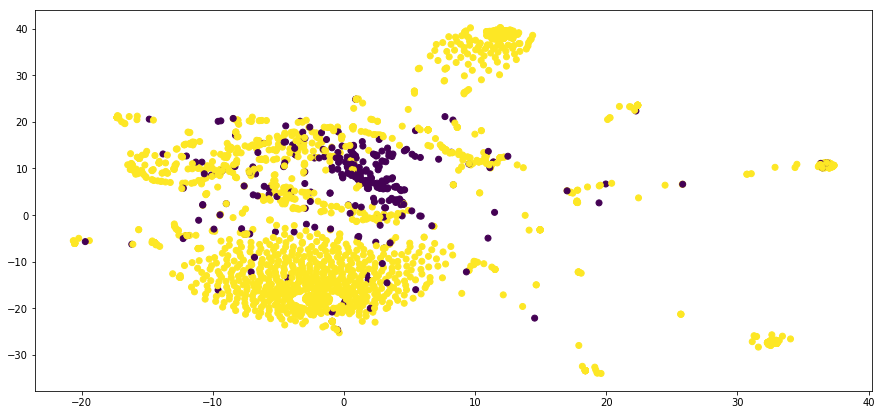

In [22]:
from sklearn.manifold import TSNE
viz = TSNE().fit_transform(valid_players[valid_players.columns[1:-2]].values[:2000])
fig = plt.figure(figsize=(15, 7))
plt.scatter(viz[:,0], viz[:,1], c=(valid_players['y'].values[:2000] == 0).astype(int))

Итак, человек останется, если проведет 3 или больше дней:

In [54]:
valid_players['will_stay'] = (valid_players['y'] > 2).astype(int)
classif_df = valid_players.drop(['y'], axis=1)

Сделаем разделение по времени: в обучающей выборке игроки, начавшие играть раньше, чем в игроки из тестовой (дата выбрана исходя из пропорции размер обучеющей:размер тестовой = примерно 4:1):

In [55]:
x_columns = classif_df.columns[1:-2].tolist()
X_train = classif_df[classif_df['first_appearance'] < '2017-03-30'][x_columns].values
y_train = classif_df[classif_df['first_appearance'] < '2017-03-30'][classif_df.columns[-1]].values
X_test = classif_df[classif_df['first_appearance'] >= '2017-03-30'][x_columns].values
y_test = classif_df[classif_df['first_appearance'] >= '2017-03-30'][classif_df.columns[-1]].values

Обучим несколько моделей и сравним результаты. Сначала попробуем модели только на стандартных признаках:

**GradientBoostingClassifier**

Подберем гиперпараметры:

In [309]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [50,100,200,500,1000],
    'learning_rate': [0.01, 0.05, 0.1]
}

gr = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'n_estimators': 500, 'learning_rate': 0.01}


In [311]:
param_grid = {
    'max_depth':range(5,16,2),
    'min_samples_split':range(200,1001,200)
}
gr = GridSearchCV(GradientBoostingClassifier(learning_rate=0.01, n_estimators=500), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'max_depth': 5, 'min_samples_split': 800}


In [57]:
model=GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,max_depth=5,min_samples_split=800)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     25842
          1       0.87      0.84      0.85      1869

avg / total       0.98      0.98      0.98     27711

[[25603   239]
 [  299  1570]]


Т.к. гиперпараметры подбирались долго (много деревьев), а результат почти не менялся, я не стал подбирать остальные.

**CatBoostClassifier**

In [292]:
param_grid = {
    'learning_rate': [i/10.0 for i in range(0,5)],
    'l2_leaf_reg': [0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}

gr = GridSearchCV(CatBoostClassifier(), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'l2_leaf_reg': 100, 'learning_rate': 0.1}


In [25]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(l2_leaf_reg=100, learning_rate=0.1, auto_stop_pval=1e-10, eval_metric='Recall')
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [26]:
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     25842
          1       0.86      0.84      0.85      1869

avg / total       0.98      0.98      0.98     27711

[[25589   253]
 [  298  1571]]


**XGBClassifier**

In [243]:
param_grid_xgcl_1 = {
    'n_estimators':[50,100,200,500,1000]
}
gr = GridSearchCV(XGBClassifier(), param_grid_xgcl_1, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'n_estimators': 100}


In [242]:
param_grid_xgcl_1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gr = GridSearchCV(XGBClassifier(), param_grid_xgcl_1, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'max_depth': 3, 'min_child_weight': 3}


In [251]:
param_grid_xgcl_2 = {
     'gamma':[i/10.0 for i in range(0,5)],
     'learning_rate': [i/10.0 for i in range(1,5)]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3), param_grid_xgcl_2, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'gamma': 0.2, 'learning_rate': 0.1}


In [252]:
param_grid_xgcl_3 = {
     'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1), param_grid_xgcl_3, 
                  scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'reg_alpha': 0.01}


In [253]:
param_grid_xgcl_4 = {
    'subsample':[i/10.0 for i in range(1,11)],
    'colsample_bytree':[i/10.0 for i in range(1,11)]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1, reg_alpha=0.01), 
                  param_grid_xgcl_4, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'subsample': 0.5, 'colsample_bytree': 0.7}


In [29]:
from xgboost import XGBClassifier
cl = XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1, reg_alpha=0.01, subsample=0.5,
                   colsample_bytree=0.7)
cl.fit(X_train, y_train)
pred = cl.predict(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     25842
          1       0.87      0.83      0.85      1869

avg / total       0.98      0.98      0.98     27711

[[25611   231]
 [  313  1556]]


Оценим важность признаков в полученной модели:

Top 5 features:
1. day_num_29 (0.130045)
2. day_num_28 (0.067265)
3. day_num_27 (0.044843)
4. day_num_24 (0.043348)
5. day_num_20 (0.043348)


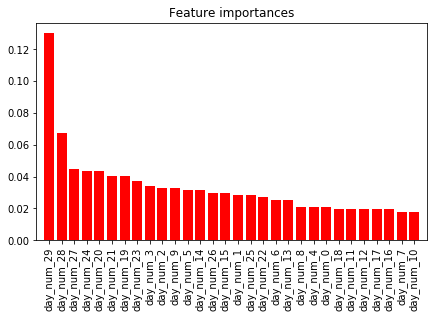

In [34]:
importances = cl.feature_importances_
indices = np.argsort(importances)[::-1]
print("Top 5 features:")
for f in range(5):
    print("%d. %s (%f)" % (f + 1, x_columns[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(7,4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), np.array(x_columns)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Ожидаемо, наибольшую важность имеют признаки, характеризующие количество сессий в последние дни наблюдаемого периода, так как если человек до сих пор продолжает играть в 27-28-29-30 дни, вероятность того, что он и впредь будет играть, сильно повышается.

В целом, результат по разным моделям получился примерно одинаковым.

-----------------------------------------------
Так как данных в обучающей выборке много, при добавлении новых признаков я ловил MemoryError, так что обучал на исходных данных. Попробуем модель **новые признаки + PCA + xgboost**:

In [60]:
classif_df['std'] = classif_df[classif_df.columns[1:-2]].std(axis=1)
classif_df['min'] = classif_df[classif_df.columns[1:-2]].min(axis=1)
classif_df['max'] = classif_df[classif_df.columns[1:-2]].max(axis=1)
classif_df['mean'] = classif_df[classif_df.columns[1:-2]].mean(axis=1)
classif_df['median'] = classif_df[classif_df.columns[1:-2]].median(axis=1)

In [71]:
x_columns = classif_df.columns[1:-7].tolist() + classif_df.columns[-5:].tolist()
X_train = classif_df[classif_df['first_appearance'] < '2017-03-30'][x_columns].values
y_train = classif_df[classif_df['first_appearance'] < '2017-03-30'][classif_df.columns[-6]].values
X_test = classif_df[classif_df['first_appearance'] >= '2017-03-30'][x_columns].values
y_test = classif_df[classif_df['first_appearance'] >= '2017-03-30'][classif_df.columns[-6]].values

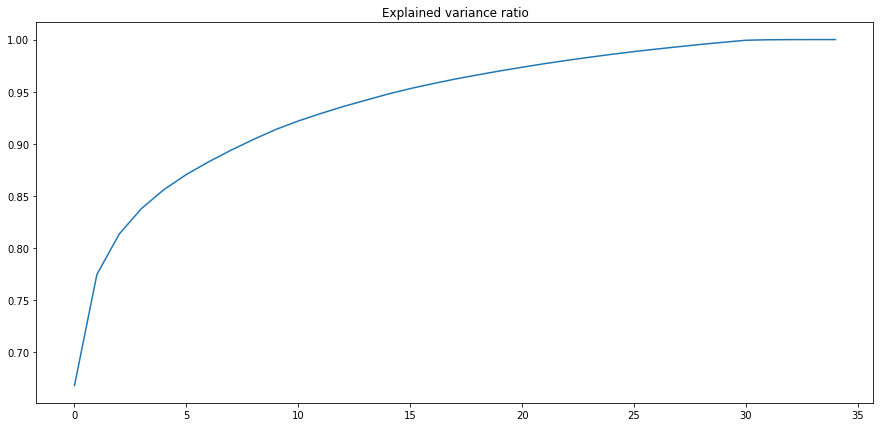

In [72]:
from sklearn.decomposition import PCA
plt.figure(figsize=(15,7))
plt.plot(PCA().fit(X_train).explained_variance_ratio_.cumsum())
plt.title('Explained variance ratio')

Излом при n=4

In [68]:
pca = PCA(n_components=4)
X_train_tr = pca.fit_transform(X_train)
X_test_tr = pca.transform(X_test)

In [69]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_tr, y_train)
pred = model.predict(X_test_tr)

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98     25842
          1       0.82      0.74      0.78      1869

avg / total       0.97      0.97      0.97     27711

[[25540   302]
 [  489  1380]]


## Регрессия

Для тех, кто останется, предскажем количество дней, которое они проведут в игре в следующие две недели::

In [36]:
regr_data = valid_players[valid_players['will_stay'] == 1].drop(['will_stay'], axis=1)

Добавим признаков:

In [37]:
regr_data['sessions_std'] = regr_data[regr_data.columns[:-1]].std(axis=1)
#regr_data['min'] = regr_data[regr_data.columns[:-1]].min(axis=1)
regr_data['sessions_max'] = regr_data[regr_data.columns[:-1]].max(axis=1)
regr_data = regr_data.merge(data.groupby(['id'])[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std'}), on='id', how='left')
#regr_data = regr_data.merge(data.groupby(['id'])[['session_length']].min().reset_index(), on='id', how='left')

In [38]:
x_columns = regr_data.columns.tolist()[1:-5] + regr_data.columns.tolist()[-3:]
X_train = regr_data[regr_data['first_appearance'] < '2017-03-30'][x_columns].values
y_train = regr_data[regr_data['first_appearance'] < '2017-03-30'][regr_data.columns[-4]].values
X_test = regr_data[regr_data['first_appearance'] >= '2017-03-30'][x_columns].values
y_test = regr_data[regr_data['first_appearance'] >= '2017-03-30'][regr_data.columns[-4]].values

Попробуем **CatBoost**:

In [259]:
param_grid = {
    'learning_rate': [i/10.0 for i in range(0,5)],
    'l2_leaf_reg': [0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}

gr = GridSearchCV(CatBoostRegressor(), param_grid, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'l2_leaf_reg': 0.01, 'learning_rate': 0.1}


In [41]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
model = CatBoostRegressor(l2_leaf_reg=0.01, learning_rate=0.1, auto_stop_pval=1e-10, eval_metric='MAE')
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                       np.sqrt(mean_squared_error(y_test, pred))))

MAE: 1.8427
r2: 0.5597
RMSE: 2.6329


Попробуем **xgboost**:

In [42]:
from xgboost import XGBRegressor

In [209]:
param_grid_xgreg_1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators':np.arange(100,1000,200)
}

gr = GridSearchCV(XGBRegressor(), param_grid_xgreg_1, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'max_depth': 5, 'n_estimators': 100, 'min_child_weight': 3}


In [212]:
param_grid_xgreg_2 = {
    'gamma':[i/10.0 for i in range(0,5)],
    'learning_rate': [i/10.0 for i in range(0,5)]
}
gr = GridSearchCV(XGBRegressor(max_depth=5, min_child_weight=3), param_grid_xgreg_2, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'gamma': 0.1, 'learning_rate': 0.1}


In [224]:
param_grid_xgreg_3 = {
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}
gr = GridSearchCV(XGBRegressor(max_depth=5, min_child_weight=3, gamma=0.1, learning_rate=0.1), param_grid_xgreg_3, 
                  scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'reg_alpha': 1e-05}


In [233]:
param_grid_xgreg_4 = {
    'subsample':[i/10.0 for i in range(1,11)],
    'colsample_bytree':[i/10.0 for i in range(1,11)]
}
gr = GridSearchCV(XGBRegressor(max_depth=5, min_child_weight=3, gamma=0.1, learning_rate=0.1), param_grid_xgreg_4, 
                  scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'subsample': 1.0, 'colsample_bytree': 1.0}


In [39]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = XGBRegressor(max_depth=5, min_child_weight=3, gamma=0.1, learning_rate=0.1, reg_alpha=1e-05, subsample=1, 
                     colsample_bytree=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                       np.sqrt(mean_squared_error(y_test, pred))))

MAE: 1.7956
r2: 0.5643
RMSE: 2.6193


Оценим важность признаков: (f0-f29 - дни 0-29)

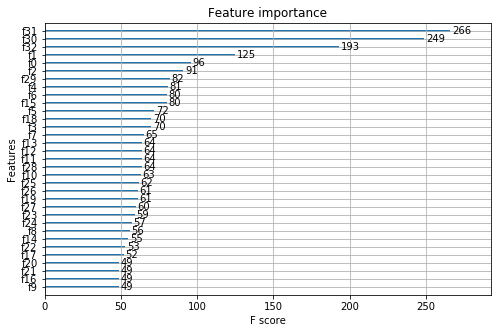

In [51]:
from xgboost import plot_importance
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(8, 5)

In [278]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

for train_index, test_index in kf.split(X_train):
    model.fit(X_train[train_index], y_train[train_index])
    pred = model.predict(X_train[test_index])
    print(mean_absolute_error(pred, y_train[test_index]))

1.61737028052
1.62808481735
1.63702852842


По более старым данным качество лучше, т.е. разбивать на обучение и тест по времени важно

# Результат

Здесь представлены не все методы, которые я испробовал, а в большинстве только те, что дали наилуший результат. Например, PCA в регрессии не привел к хорошим результатам, так что я не стал его оставлять. Также я добавлял другие признаки, но какие-то из них не привнесли ничего нового. 